<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/10_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 10: Bayesian Neural Networks

The notebook is a revisitation of [this tutorial](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd).

![](https://github.com/charlesollion/dlexperiments/raw/master/6-Bayesian-DL/BDLworkflow.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
%matplotlib inline

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:

class NN(nn.Module):
	
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('~/.pytorch/MNIST_data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('~/.pytorch/MNIST_data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

In [3]:
log_softmax = nn.LogSoftmax(dim=1)

In [4]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)).to_event(net.fc1.weight.dim())
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias)).to_event(net.fc1.bias.dim())
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)).to_event(net.out.weight.dim())
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)).to_event(net.out.bias.dim())
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    
    with pyro.plate("data", len(x_data)):
        out = lifted_reg_model(x_data) # out.shape = (batch_size, num_classes)
        obs = pyro.sample("obs", Categorical(logits=out), obs=y_data) # obs.shape = (batch_size)


In [5]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    # torch.randn_like returns a tensor with the same shape as the input tensor filled with random numbers from a normal distribution with mean 0 and variance 1
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).to_event(net.fc1.weight.dim())
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param).to_event(net.fc1.bias.dim())
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).to_event(net.out.weight.dim())
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param).to_event(net.out.bias.dim())
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [6]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [7]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/Users/rominadoz/micromamba/envs/neuralodes/lib/python3.11/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch  0  Loss  2075.902325265511
Epoch  1  Loss  361.49907664847376
Epoch  2  Loss  155.47973459606172
Epoch  3  Loss  110.10635602215132
Epoch  4  Loss  95.71016311481793


In [8]:

num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (np.array(predicted) == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 89 %


In [9]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
num_samples = 10

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()   
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0
    for i in range(len(labels)):    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2)) 
        all_digits_prob = []  
        highted_something = False  
        for j in range(len(classes)):       
            highlight=False    
            histo = []
            histo_exp = []       
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))  
            prob = np.percentile(histo_exp, 50) #sampling median probability
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer       
            all_digits_prob.append(prob)           
            if(plot):           
                N, bins, patches = axs[j].hist(histo, bins=10, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")")      
            if(highlight):        
                highted_something = True           
                if(plot):
                    fracs = N / N.max()
                    norm = colors.Normalize(fracs.min(), fracs.max())
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)   
        if(plot):
            plt.show()
        predicted = np.argmax(all_digits_prob)  
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")    
        if(plot):
            imshow(images[i].squeeze())    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 
    
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  814
Accuracy when made predictions: 92 %


Real:  8


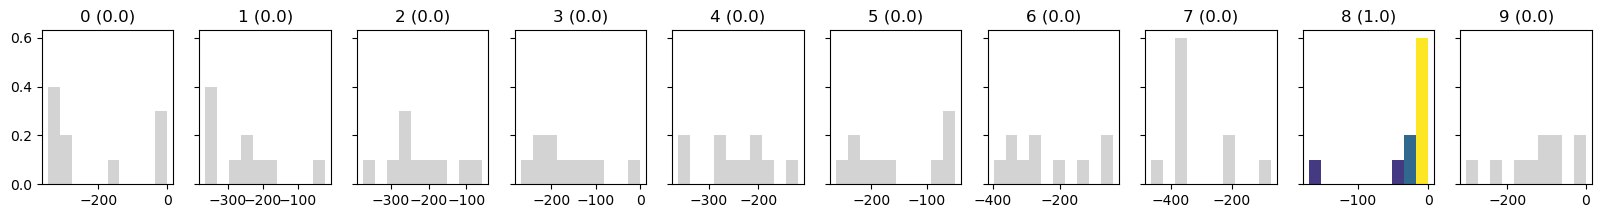

Correct


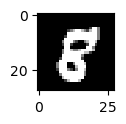

Real:  4


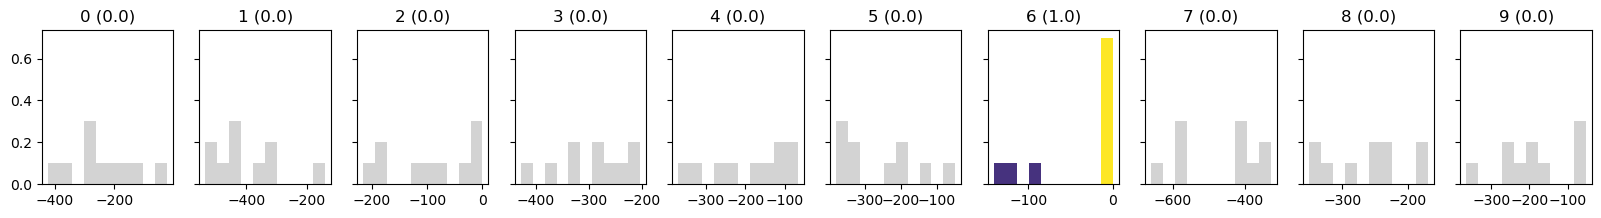

Incorrect :()


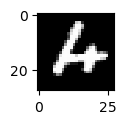

Real:  7


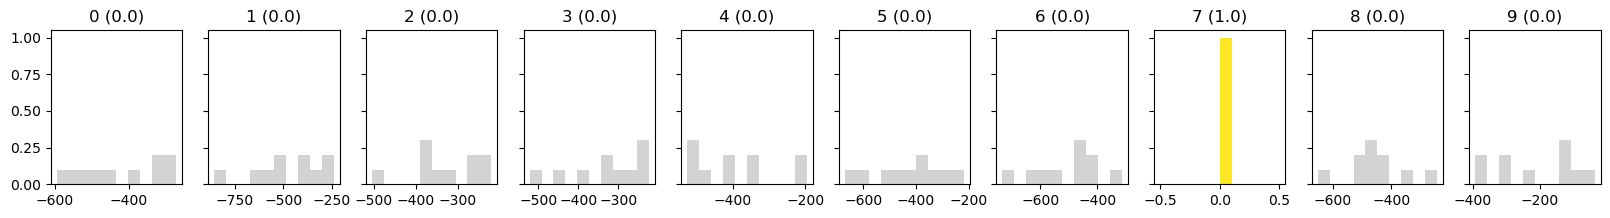

Correct


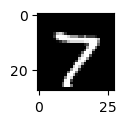

Real:  3


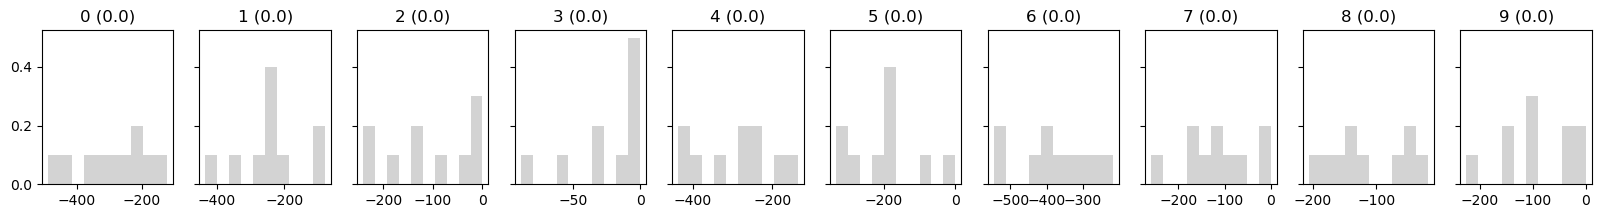

Undecided.


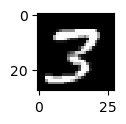

Real:  7


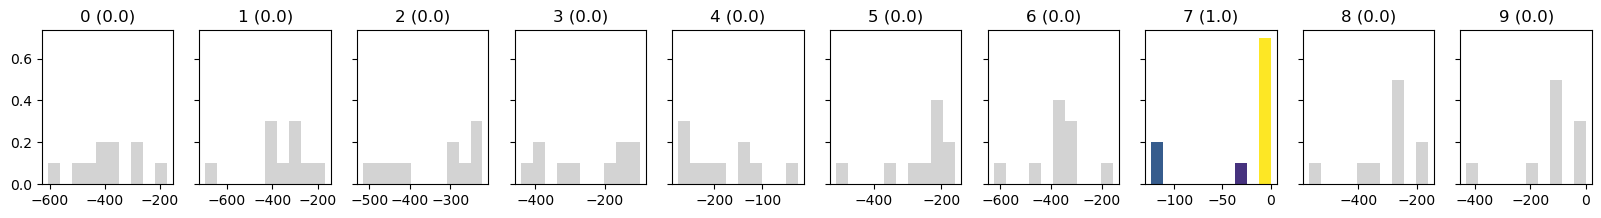

Correct


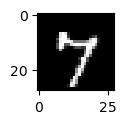

Real:  5


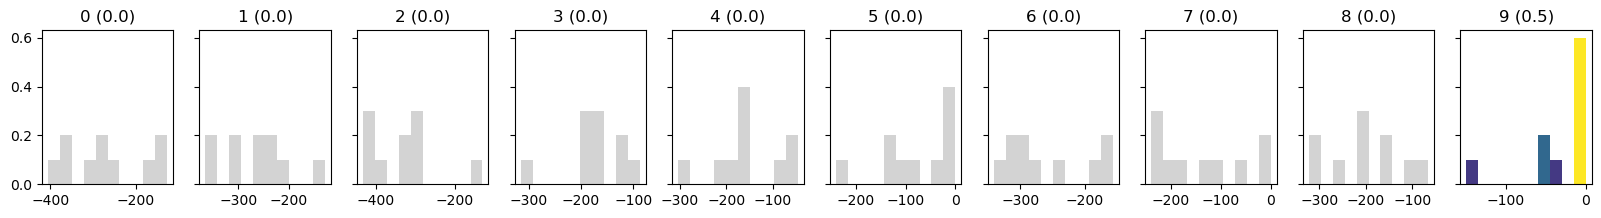

Incorrect :()


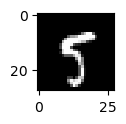

Real:  7


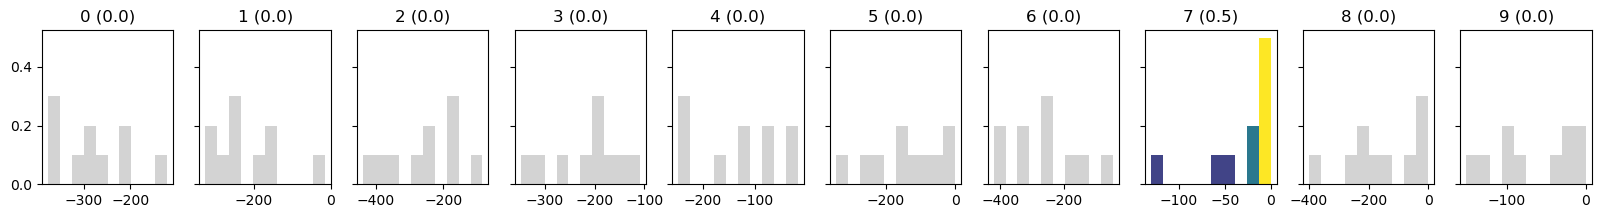

Correct


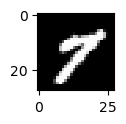

Real:  2


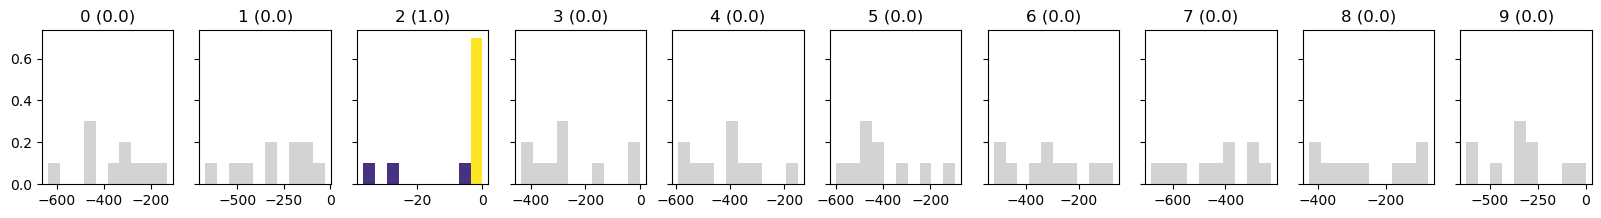

Correct


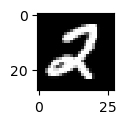

Real:  1


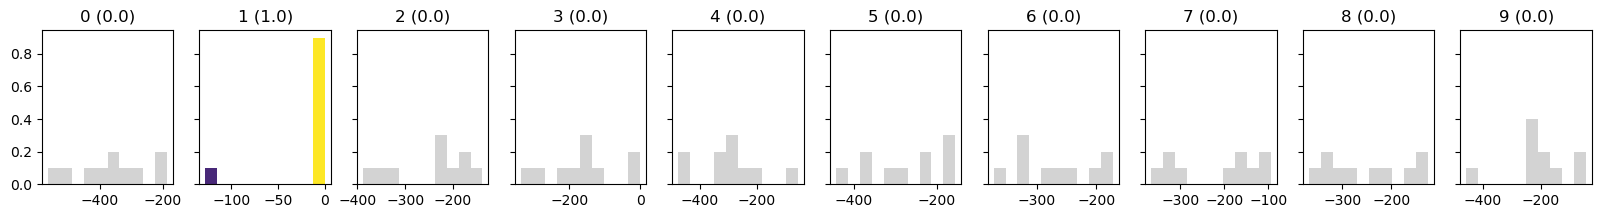

Correct


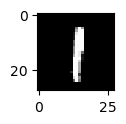

Real:  5


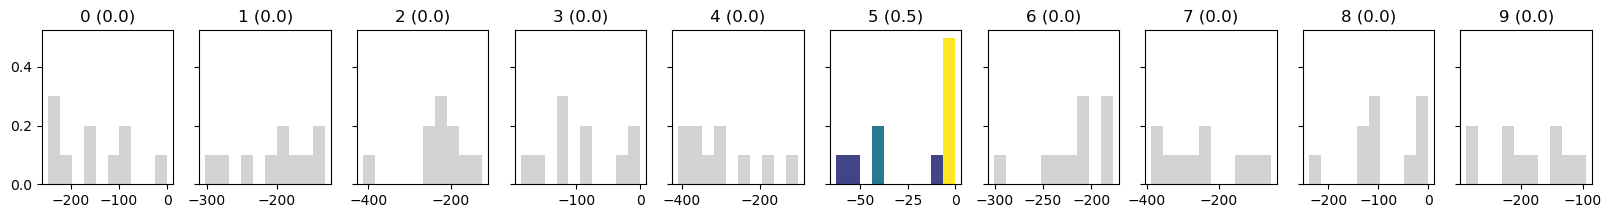

Correct


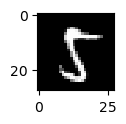

Summary
Total images:  10
Predicted for:  9
Accuracy when predicted:  0.7777777777777778


In [10]:
for images, labels in test_loader:
    test_batch(images[10:20], labels[10:20])
    break

In [11]:
test_loader_fashion = torch.utils.data.DataLoader(datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=False, download = True, transform=transforms.Compose([transforms.ToTensor(),])),batch_size=128, shuffle=True)

tensor([9, 3, 5, 1, 8, 0, 7, 3, 6, 3])
Real:  9


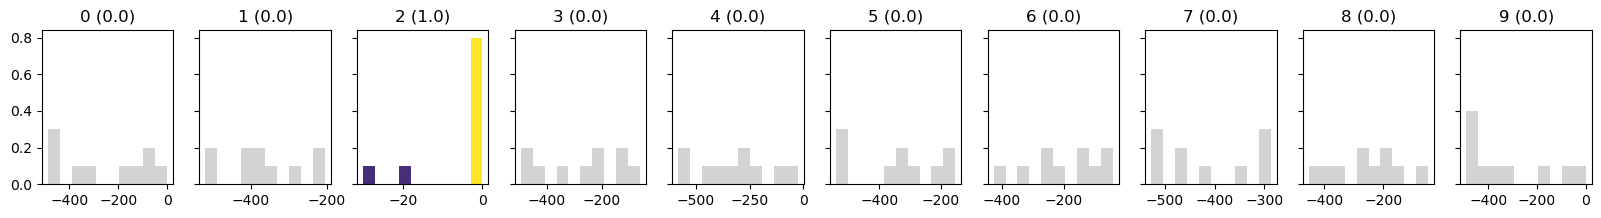

Incorrect :()


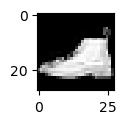

Real:  3


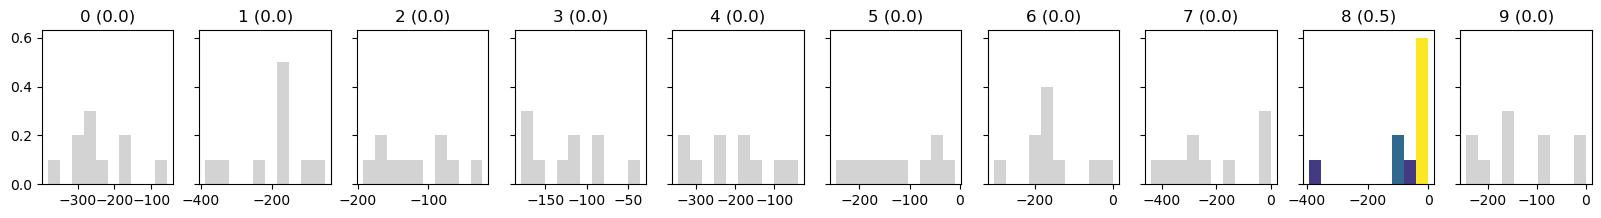

Incorrect :()


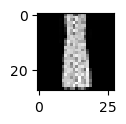

Real:  5


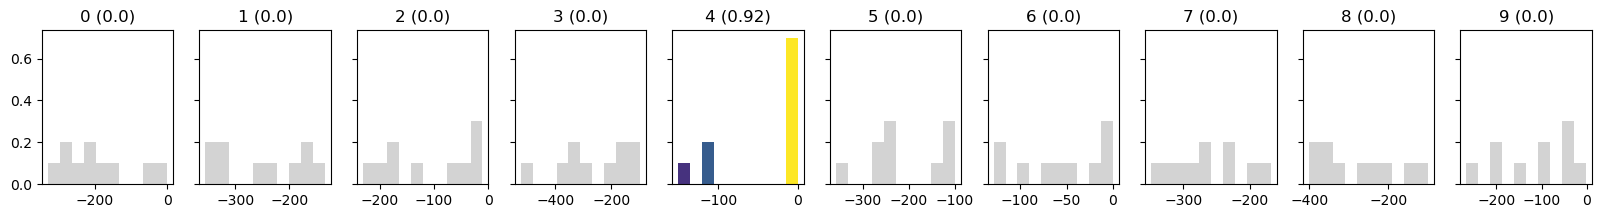

Incorrect :()


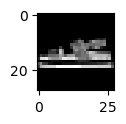

Real:  1


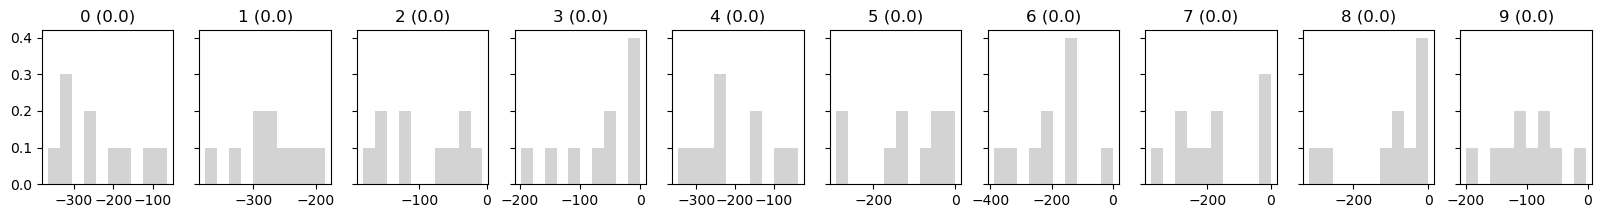

Undecided.


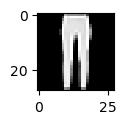

Real:  8


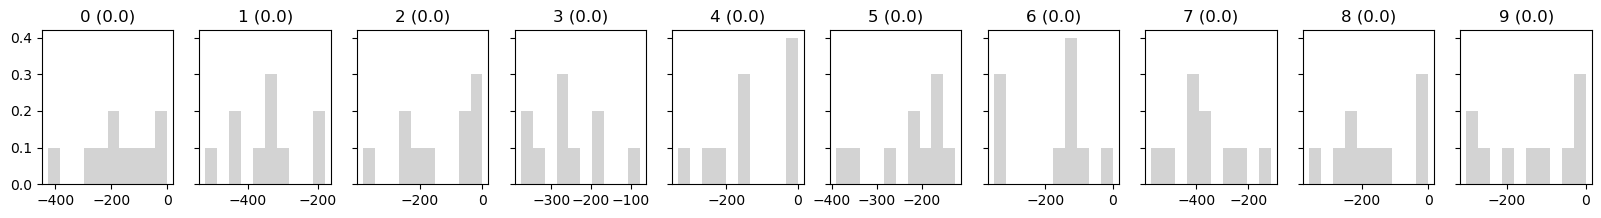

Undecided.


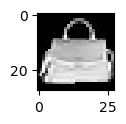

Real:  0


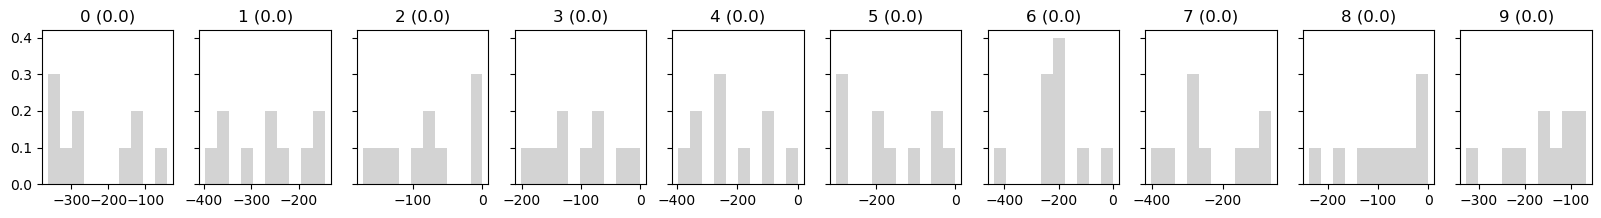

Undecided.


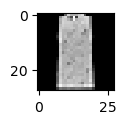

Real:  7


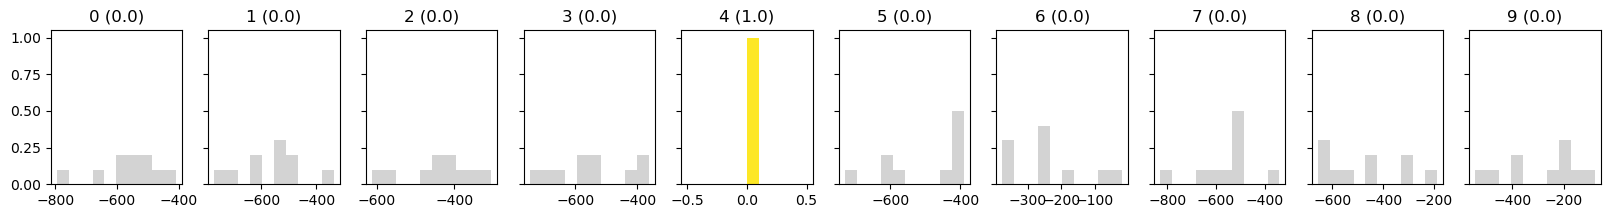

Incorrect :()


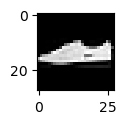

Real:  3


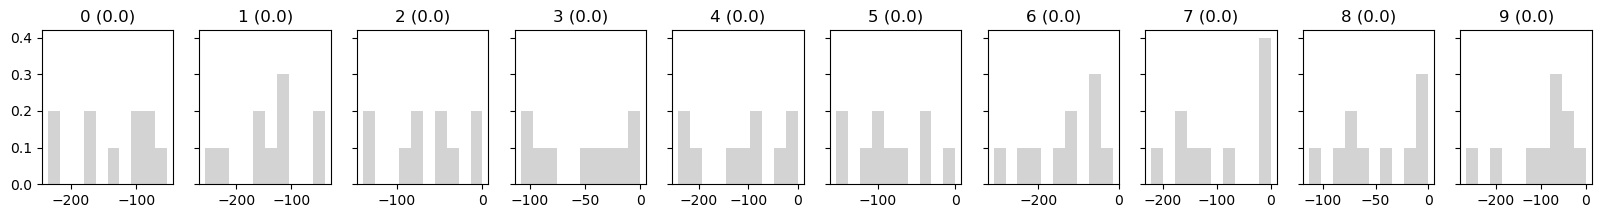

Undecided.


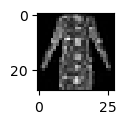

Real:  6


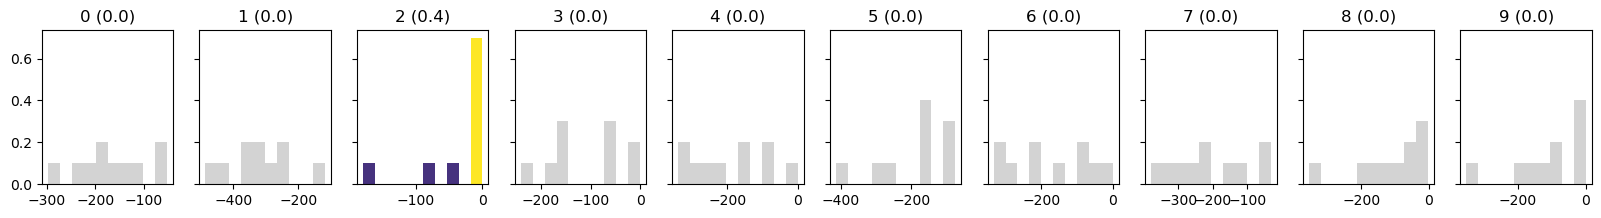

Incorrect :()


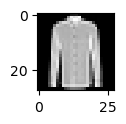

Real:  3


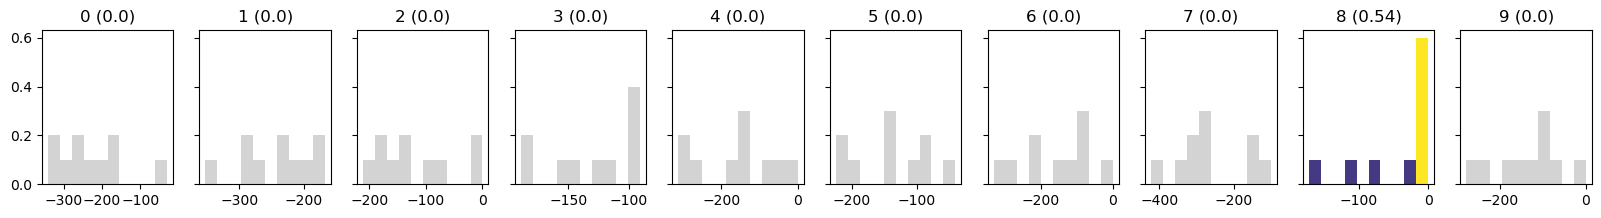

Incorrect :()


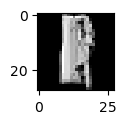

Summary
Total images:  10
Predicted for:  6
Accuracy when predicted:  0.0


In [12]:
for images, labels in test_loader_fashion:
    print(labels[10:20])
    test_batch(images[10:20], labels[10:20])
    break